In [16]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import pandas as pd
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import LearningRateScheduler

In [ ]:
# Define paths
train_path = 'kidney_split_dataset/train'
val_path = 'kidney_split_dataset/validation'
test_path = 'kidney_split_dataset/test'

# Data augmentation for training data
# train_datagen = ImageDataGenerator(
#     rescale=1.0 / 255.0,
#     rotation_range=15,  # Reduce rotation range to avoid unnatural orientations
#     width_shift_range=0.1,  # Slight horizontal shift
#     height_shift_range=0.1,  # Slight vertical shift
#     zoom_range=0.1,  # Small zoom variations
#     brightness_range=[0.9, 1.1],  # Controlled brightness adjustments
#     horizontal_flip=False,  # Avoid flipping for medical images unless symmetry is acceptable
#     vertical_flip=False,  # Typically not appropriate for medical imaging
#     shear_range=0.05,  # Minor shearing to add variety
#     fill_mode='nearest'  # Fill missing areas with the nearest pixel values
# )

train_datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,
    rotation_range=10,  # Smaller rotation to reduce unnecessary distortion
    width_shift_range=0.05,  # Minimal horizontal shift
    height_shift_range=0.05,  # Minimal vertical shift
    zoom_range=0.05,  # Minor zoom adjustments
    fill_mode='nearest'  # Fill missing areas with the nearest pixel values
)


val_datagen = ImageDataGenerator(rescale=1.0/255.0)

train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(128, 128),
    color_mode='grayscale',
    batch_size=32,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_path,
    target_size=(128, 128),
    color_mode='grayscale',
    batch_size=32,
    class_mode='categorical'
)

test_generator = val_datagen.flow_from_directory(
    test_path,
    target_size=(128, 128),
    color_mode='grayscale',
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)
# Gpt prompt: explain how to perform data augmentation and explain each step

Found 9954 images belonging to 4 classes.
Found 1246 images belonging to 4 classes.
Found 1246 images belonging to 4 classes.


In [18]:
#Compute Class Weights
classes = list(train_generator.class_indices.keys())
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights_dict = dict(enumerate(class_weights))
print("Computed Class Weights:", class_weights_dict)


Computed Class Weights: {0: 0.8387259858442871, 1: 0.6127801034228023, 2: 2.260217983651226, 3: 1.3635616438356164}


In [19]:
# Define the model
model = Sequential([
    Flatten(input_shape=(128, 128, 1)),

    Dense(2048, activation='relu', kernel_regularizer=l2(0.0001)),
    #BatchNormalization(),
    Dropout(0.3),

    Dense(1024, activation='relu', kernel_regularizer=l2(0.0001)),
    #BatchNormalization(),
    Dropout(0.2),

    Dense(512, activation='relu', kernel_regularizer=l2(0.0001)),
    #BatchNormalization(),
    Dropout(0.2),
    
    # Dense(256, activation='relu'),
    # BatchNormalization(),
    # Dropout(0.4),
    # Dense(128, activation='relu', kernel_regularizer=l2(0.1)),
    # BatchNormalization(),
    # Dropout(0.4),
    # Dense(64, activation='relu', kernel_regularizer=l2(0.1)),
    # BatchNormalization(),
    # Dropout(0.4),
    Dense(4, activation='softmax')
])
model.summary()
 #kernel_regularizer=l2(0.00005)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 16384)             0         
                                                                 
 dense_4 (Dense)             (None, 2048)              33556480  
                                                                 
 dropout_3 (Dropout)         (None, 2048)              0         
                                                                 
 dense_5 (Dense)             (None, 1024)              2098176   
                                                                 
 dropout_4 (Dropout)         (None, 1024)              0         
                                                                 
 dense_6 (Dense)             (None, 512)               524800    
                                                                 
 dropout_5 (Dropout)         (None, 512)              

In [20]:
# # Updated Learning Rate Scheduler
# def lr_schedule(epoch, lr):
#     if epoch < 5:
#         return 0.001  # Higher initial learning rate
#     elif epoch < 15:
#         return 0.0005  # Moderate decay
#     elif epoch < 30:
#         return 0.00025
#     else:
#         return 0.0001  # Further decay

# lr_scheduler = LearningRateScheduler(lr_schedule, verbose=1)

In [21]:
# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [22]:
# Callbacks
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=4,
    min_lr=1e-6,
    verbose=1
)
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True,
    verbose=1
)

In [23]:
# Train the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30,
    class_weight=class_weights_dict,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/30
312/312 [==============================] - 28s 89ms/step - loss: 1.7189 - accuracy: 0.4278 - val_loss: 1.1443 - val_accuracy: 0.6108 - lr: 0.0010
Epoch 2/30
312/312 [==============================] - 27s 86ms/step - loss: 1.2211 - accuracy: 0.5767 - val_loss: 0.9132 - val_accuracy: 0.6878 - lr: 0.0010
Epoch 3/30
312/312 [==============================] - 27s 86ms/step - loss: 1.0998 - accuracy: 0.6133 - val_loss: 0.8493 - val_accuracy: 0.7087 - lr: 0.0010
Epoch 4/30
312/312 [==============================] - 27s 86ms/step - loss: 1.0079 - accuracy: 0.6454 - val_loss: 0.6642 - val_accuracy: 0.8347 - lr: 0.0010
Epoch 5/30
312/312 [==============================] - 27s 86ms/step - loss: 0.9402 - accuracy: 0.6683 - val_loss: 0.5722 - val_accuracy: 0.8708 - lr: 0.0010
Epoch 6/30
312/312 [==============================] - 27s 86ms/step - loss: 0.9263 - accuracy: 0.6759 - val_loss: 0.6104 - val_accuracy: 0.8684 - lr: 0.0010
Epoch 7/30
312/312 [==============================] - 27s 

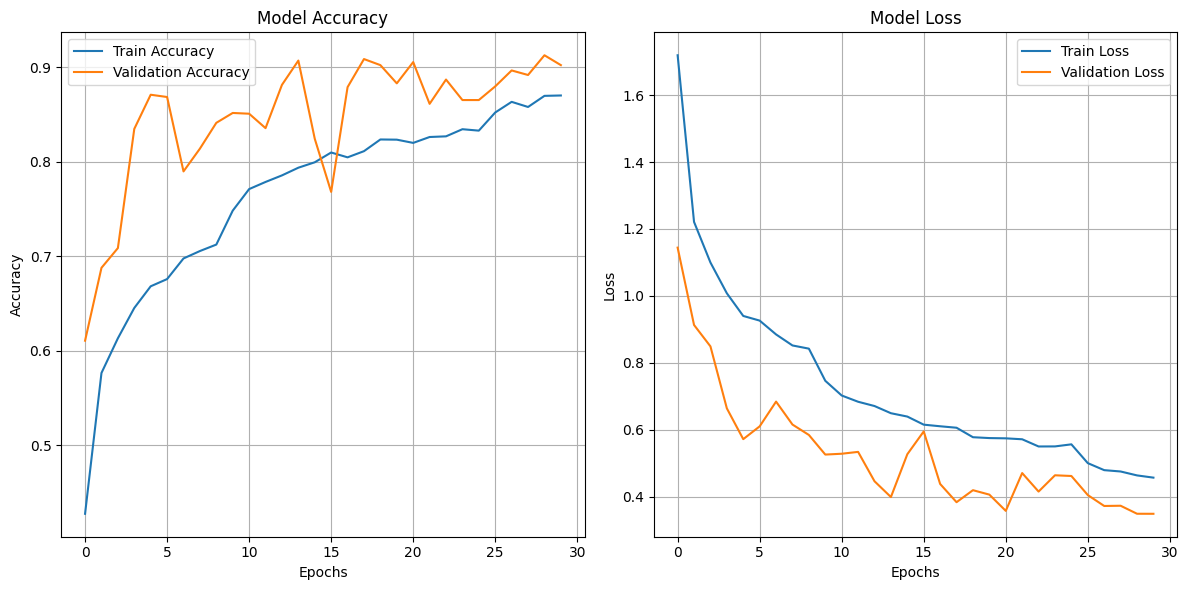

In [24]:
# Convert history to DataFrame
history_df = pd.DataFrame(history.history)

# Plot Training History
plt.figure(figsize=(12, 6))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history_df['accuracy'], label='Train Accuracy')
plt.plot(history_df['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history_df['loss'], label='Train Loss')
plt.plot(history_df['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [25]:
# Evaluate on Test Data
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


39/39 [==============================] - 3s 66ms/step - loss: 0.3432 - accuracy: 0.9165
Test Loss: 0.3432450294494629
Test Accuracy: 0.9165329337120056


39/39 [==============================] - 3s 65ms/step


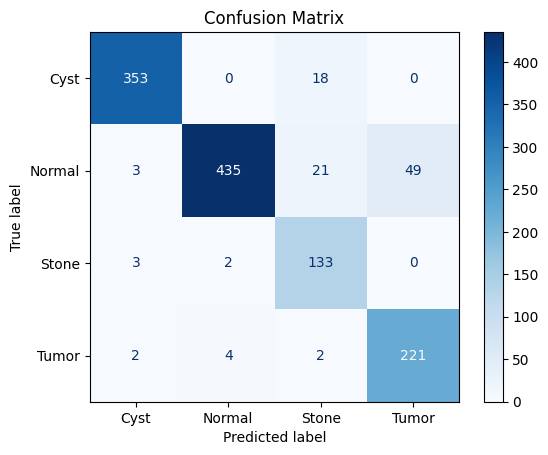

Classification Report:
              precision    recall  f1-score   support

        Cyst       0.98      0.95      0.96       371
      Normal       0.99      0.86      0.92       508
       Stone       0.76      0.96      0.85       138
       Tumor       0.82      0.97      0.89       229

    accuracy                           0.92      1246
   macro avg       0.89      0.93      0.90      1246
weighted avg       0.93      0.92      0.92      1246



In [26]:
# Confusion Matrix and Classification Report
y_pred_proba = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred_proba, axis=1)
y_true = test_generator.classes

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_generator.class_indices.keys())
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=list(test_generator.class_indices.keys())))
